# Canny Edge Detection Self-implementation

**Setup and import.**

In [330]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import feature, data
from time import time


# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# function to show images
def display(img, title=None, cm="gray"):
    plt.figure(figsize = (8,8))
    if cm == "rgb":
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

**Load test images.**

In [331]:
OGeinstein = cv2.imread('./images/noisy_einstein.png')
OGroad = cv2.cvtColor(cv2.imread('./images/road.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) # read in color then convert from bgr to rgb :roll eyes:
OGiguana = cv2.imread('./images/iguana.png')
OGbaboon = cv2.cvtColor(cv2.imread('./images/baboon.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
OGlady = cv2.imread('./images/lady.png')
OGbridge = cv2.cvtColor(cv2.imread('./images/bridge.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
OGcoins = data.coins()

TESTeinstein = OGeinstein
TESTroad = OGroad
TESTiguana = OGiguana
TESTbaboon = OGbaboon
TESTlady = OGlady
TESTbridge = OGbridge
TESTcoins = OGcoins

**Create a naive convolutional filter implementation using numpy (based on filters assignment).**

In [332]:
def ncf(image, kernel): # edge_behavior="zero"
    
    image = np.asarray(image)
    kernel = np.asarray(kernel)
    
    # if image is rgb convert to grayscale
    if len(image.shape) == 3:
        R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
        gray_img = 0.299*R + 0.587*G + 0.114*B
        image = gray_img.copy()
    
    # add zeros around image to fix bounding problems (edge behavior)
    border0 = kernel.shape[0]//2
    border1 = kernel.shape[1]//2
    padded_image0 = image.shape[0] + 2*border0
    padded_image1 = image.shape[1] + 2*border1
    new_image = np.zeros((padded_image0, padded_image1))
    
    # put image in the middle of new_image with border around it
    new_image[border0:new_image.shape[0]-border0, border1:new_image.shape[1]-border1] = image
    new_image = new_image.astype(int)
    
    out_image = image.copy()
    out_imgae = out_image.astype(int)
    
    for image_row in range(new_image.shape[0]-kernel.shape[0]):
        for image_column in range(new_image.shape[1]-kernel.shape[1]):
            
            # slice image
            image_slice = new_image[image_row:image_row+kernel.shape[0], image_column:image_column+kernel.shape[1]]
            
            # multiply slice by kernel
            # vectorized using numpy, much faster than for loops!
            sliceXkernel = image_slice * kernel
            
            # take the sum
            output_value = np.sum(sliceXkernel)
            
            # set the new value
            out_image[image_row, image_column] = output_value
           
    return(out_image)

## 1. Remove Noise

**Define function to create a gaussian kernel using `kernel_shape` and `sigma`.**

In [333]:
def create_gaussian(kernel_shape, sigma):

    gaussian_kernel = np.empty(kernel_shape)

    for x in range(kernel_shape[0]):
        for y in range(kernel_shape[1]):
            
            xOffset = math.floor(kernel_shape[0]/2)
            yOffset = math.floor(kernel_shape[1]/2)
            
            # offset origin to center if kernel is even by even
            if kernel_shape[0] % 2 == 0: xOffset -= 0.5
            if kernel_shape[1] % 2 == 0: yOffset -= 0.5
            
            # distance from x and y to the "origin" in the middle of the kernel
            xOrigin = x - xOffset
            yOrigin = y - yOffset
            
            # function from https://en.wikipedia.org/wiki/Gaussian_filter
            gaussian_kernel[x][y] = (1/(2*np.pi*sigma**2))*np.e**(-(xOrigin**2+yOrigin**2)/(2*sigma**2))
            
    return gaussian_kernel

#### Examples (self-implementation vs. OpenCV gaussian blur):

In [334]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)

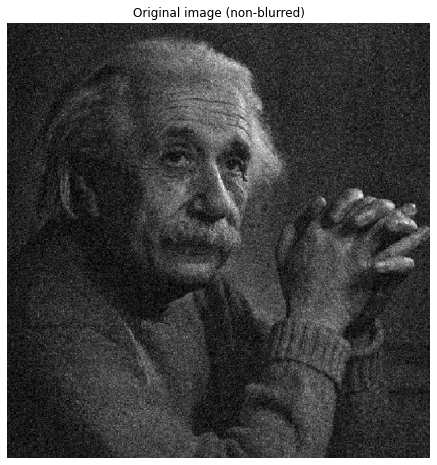

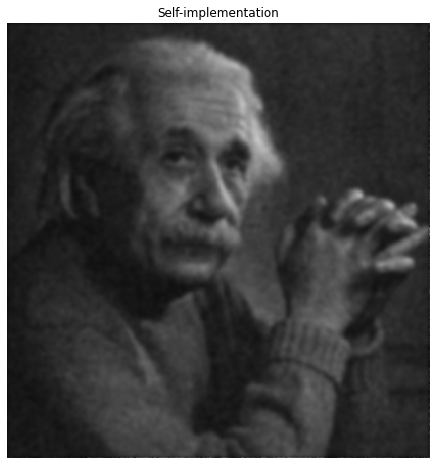

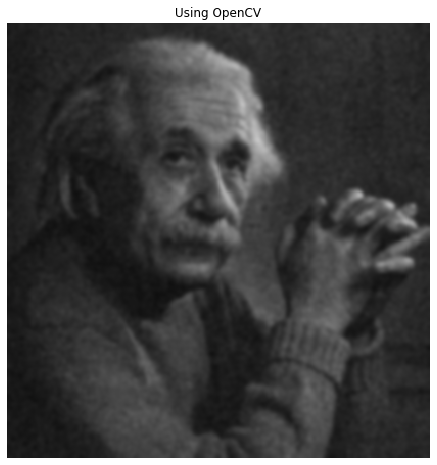

In [335]:
display(OGeinstein, "Original image (non-blurred)")
TESTeinstein = ncf(OGeinstein, GAUSSIAN_KERNEL)
display(TESTeinstein, "Self-implementation")
display(cv2.GaussianBlur(OGeinstein, KERNEL_SHAPE, SIGMA), "Using OpenCV")

## 2. Calculate Derivatives

**Create base vertical and horizontal sobel filters.**

In [336]:
_dhor = np.array(
[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

_dvert = np.array(
[
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
])

**Define merge function to combine the two gradient images.**

In [337]:
def merge(images):

    merged_image = np.sqrt(sum(np.square(img) for img in images))
    merged_image = merged_image / np.amax(merged_image) * 255
    merged_image = merged_image.astype(int)
    
    return merged_image

**Define a function that will take the derivatives of an image and return the merged image along with the slopes of the edges.**

In [338]:
def take_derivative(image, derivative_kernels):
    
    # take derivates
    derivative_images = []
    for d in derivative_kernels:
        derivative_images.append(ncf(image, d))
    
    return ({"edges":merge([img for img in derivative_images]), "slopes":np.arctan2(derivative_images[0], derivative_images[1])})

#### Examples:

In [339]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2
SOBEL_MULTIPLIER = 1

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)
DHOR = _dhor*SOBEL_MULTIPLIER
DVERT = _dvert*SOBEL_MULTIPLIER

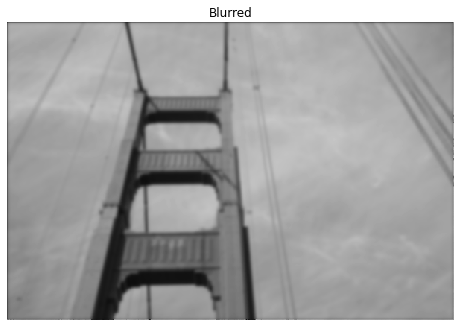

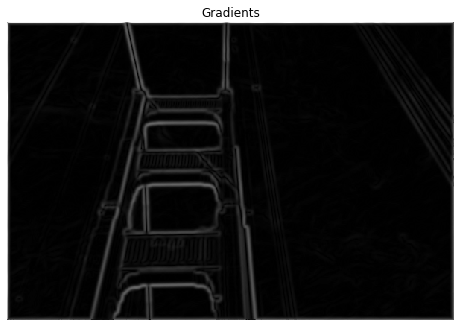

In [340]:
TESTbridge = ncf(OGbridge, GAUSSIAN_KERNEL)
display(TESTbridge, "Blurred")
TESTbridge = take_derivative(TESTbridge, [DHOR, DVERT])["edges"]
display(TESTbridge, "Gradients")

In [341]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2
SOBEL_MULTIPLIER = 1

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)
DHOR = _dhor*SOBEL_MULTIPLIER
DVERT = _dvert*SOBEL_MULTIPLIER

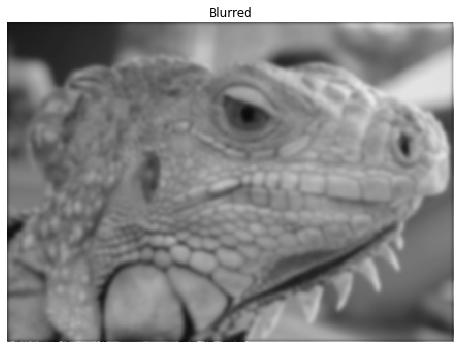

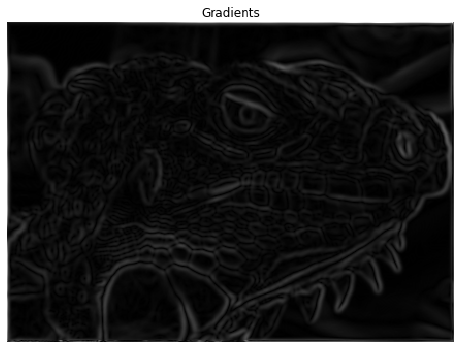

In [342]:
TESTiguana = ncf(OGiguana, GAUSSIAN_KERNEL)
display(TESTiguana, "Blurred")
TESTiguana = take_derivative(TESTiguana, [DHOR, DVERT])["edges"]
display(TESTiguana, "Gradients")

In [343]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2
SOBEL_MULTIPLIER = 0.05

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)
DHOR = _dhor*SOBEL_MULTIPLIER
DVERT = _dvert*SOBEL_MULTIPLIER

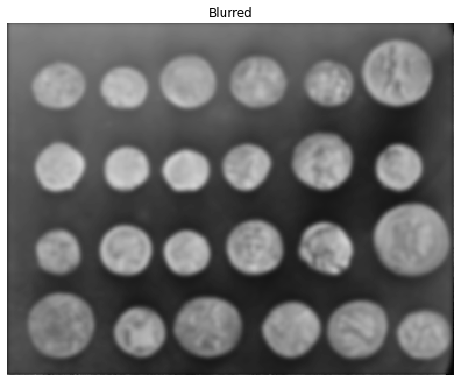

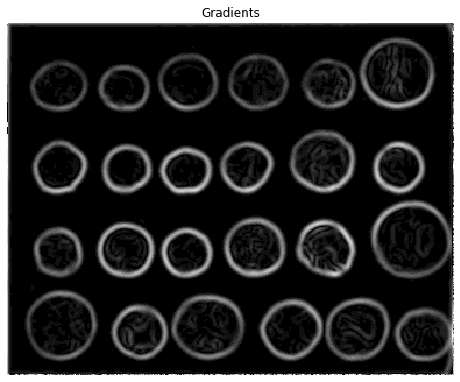

In [344]:
TESTcoins = ncf(OGcoins, GAUSSIAN_KERNEL)
display(TESTcoins, "Blurred")
TESTcoins = take_derivative(TESTcoins, [DHOR, DVERT])["edges"]
display(TESTcoins, "Gradients")

## 3. Non-maximum Supression

**Define NMS function.**

I am still stumped why the slopes don't matter at all here. Who knows. I've thought about it and drawn it out and photoshopped images to run through and it doesn't make any sense. I've had a lot of ideas, most of which have turned out to have no value. Currently, I'm stuck on why we are even inputting `derivative_images[0]` and `derivative_images[1]` into `np.arctan2`, aren't those just arrays of pixel values from 0 to 255? How would those help us find an angle that is relevant? Should we be putting something else into `np.arctan2`? Seems like it to me, but I could easily just be hallucinating because I've stared at this for too long.

In [345]:
def NMS(image, slopes):
    
    slopes = slopes * 180 / np.pi # convert angles to degrees
    slopes[slopes < 0] += 180 # fix negative values
    out_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    
    for r in range(1, image.shape[0]-1):
        for c in range(1, image.shape[1]-1):
            
            angle = slopes[r][c]

            # angle 0
#             if (157.5 <= angle <= 180) or (0 <= angle < 22.5):
            P = image[r][c-1]
            N = image[r][c+1]

#             # angle 45
#             elif (22.5 <= angle < 67.5):
#                 P = image[r+1][c-1]
#                 N = image[r-1][c+1]

#             # angle 90
#             elif (67.5 <= angle < 112.5):
#                 P = image[r+1][c]
#                 N = image[r-1][c]

#             # angle 135
#             elif (112.5 <= angle < 157.5):
#                 P = image[r-1][c+1]
#                 N = image[r+1][c-1]

            # set values in output image
            if image[r][c] >= P and image[r][c] >= N:
                out_image[r][c] = image[r][c]
            else:
                out_image[r][c] = 0
            
    return out_image

#### Examples:

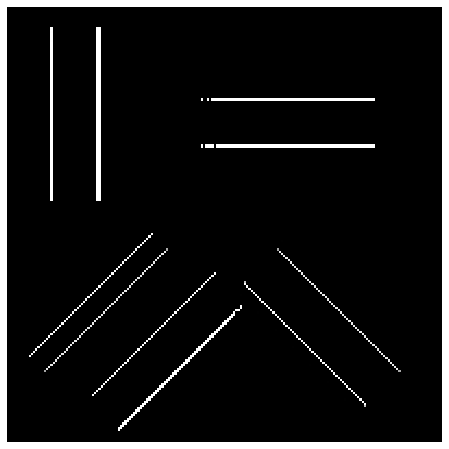

In [346]:
test_lines = cv2.imread("./test_lines-1.jpg")
test_lines = ncf(test_lines, [[1]])

d = take_derivative(ncf(test_lines, GAUSSIAN_KERNEL), [DHOR, DVERT])
TESTcoins = NMS(test_lines, d["slopes"])
display(TESTcoins)

In [347]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2
SOBEL_MULTIPLIER = 0.05

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)
DHOR = _dhor*SOBEL_MULTIPLIER
DVERT = _dvert*SOBEL_MULTIPLIER

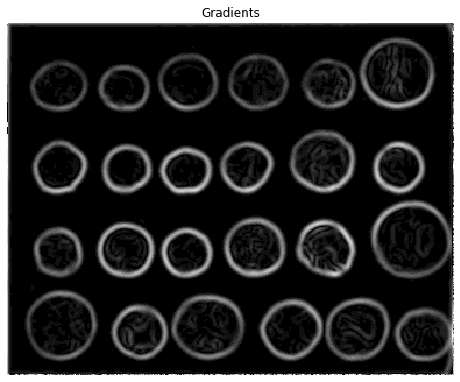

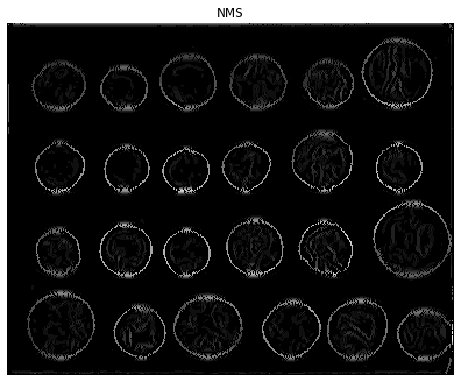

In [348]:
d = take_derivative(ncf(OGcoins, GAUSSIAN_KERNEL), [DHOR, DVERT])
display(d["edges"], "Gradients")
TESTcoins = NMS(d["edges"], d["slopes"])
display(TESTcoins, "NMS")

In [349]:
KERNEL_SHAPE = (21, 21)
SIGMA = 2
SOBEL_MULTIPLIER = 1

GAUSSIAN_KERNEL = create_gaussian(KERNEL_SHAPE, SIGMA)
DHOR = _dhor*SOBEL_MULTIPLIER
DVERT = _dvert*SOBEL_MULTIPLIER

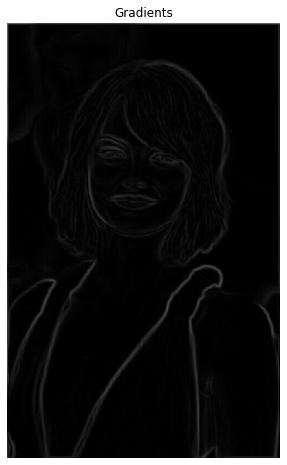

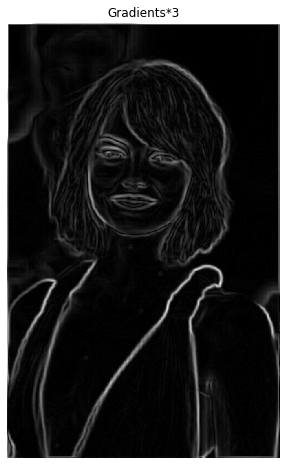

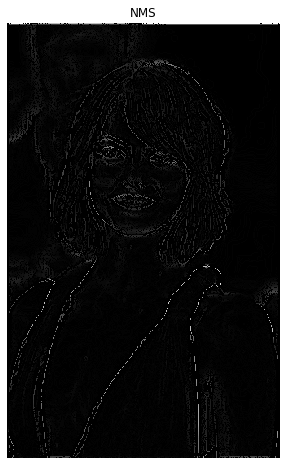

In [350]:
d = take_derivative(ncf(OGlady, GAUSSIAN_KERNEL), [DHOR, DVERT])
display(d["edges"], "Gradients")
d["edges"] *= 3
display(d["edges"], "Gradients*3")
TESTlady = NMS(d["edges"], d["slopes"])
display(TESTlady, "NMS")

## 4. Double Thresholding

**Define threshold function.**

In [351]:
def threshold(img, lowRatio=0.1, highRatio=0.2, weak=100, strong=255):
    
    highThreshold = img.max() * highRatio;
    lowThreshold = highThreshold * lowRatio;
    
    strong_locations = np.where(img >= highThreshold)
#     weak_locations = np.where((img < highThreshold) and (img >= lowThreshold))
    zero_locations = np.where(img < lowThreshold)
    
#     out_img = np.zeros((img.shape[0], img.shape[1]))
    out_img = np.full((img.shape[0], img.shape[1]), weak)
    out_img[strong_locations] = strong
    out_img[zero_locations] = 0
#     out_img[weak_locations] = weak

    return out_img.astype(int)

#### Examples:

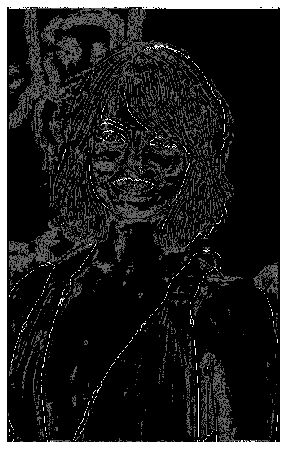

In [352]:
TESTlady = threshold(TESTlady)
display(TESTlady)

## 5. Hysteresis and Connectivity Analysis

**Define hysteresis function.**

In [353]:
def hysteresis(img, weak=100, strong=255):
    
    out_img = img.copy()
    
    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            if img[r][c] == weak:
                if ((img[r+1][c-1] == strong) or (img[r+1][c] == strong) or (img[r+1][c+1] == strong)
                    or (img[r][c-1] == strong) or (img[r][c+1] == strong)
                    or (img[r-1][c-1] == strong) or (img[r-1][c] == strong) or (img[r-1][c+1] == strong)):
                    out_img[r][c] = strong
                else:
                    out_img[r][c] = 0
                    
    return out_img

I copied and pasted `hysteresis2()` from a tutorial, I kept it because it functions slightly differently than my code and I sometimes find it useful to compare the differences. In my opinion my hysteresis function does a better job; the copy-and-paste version will often include groups of pixels that are not actually connected to strong pixels.

In [354]:
def hysteresis2(img, weak=100, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

#### Examples:

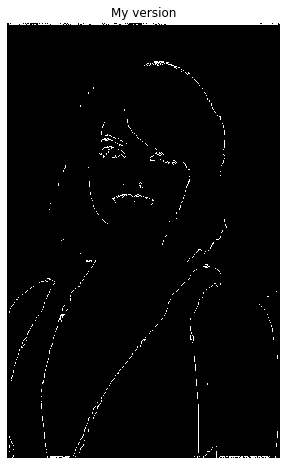

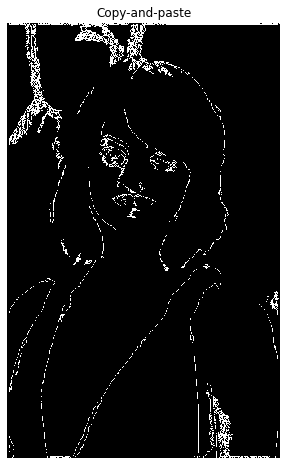

In [355]:
display(hysteresis(TESTlady), "My version")
display(hysteresis2(TESTlady), "Copy-and-paste")

## Step-by-step Visuals

**Define master function.**

In [356]:
def CED(img, show_steps=False, kernel_shape=(21,21), sigma=2, sobel_multiplier=1, gradient_multiplier=1, lowTRatio=0.1, highTRatio=0.2):

    gaussian_kernel = create_gaussian(kernel_shape, sigma)
    DHOR = _dhor*sobel_multiplier
    DVERT = _dvert*sobel_multiplier
    
    if show_steps: display(img, "Original", "rgb")
    blurred_img = ncf(img, GAUSSIAN_KERNEL)
    if show_steps: display(blurred_img, "Blurred")
    gradients_img = take_derivative(blurred_img, [DHOR, DVERT])
    if show_steps: display(gradients_img["edges"], "Gradients")
    nms_img = NMS(gradients_img["edges"]*gradient_multiplier, gradients_img["slopes"])
    if show_steps: display(nms_img, "NMS")
    threshold_img = threshold(nms_img)
    if show_steps: display(threshold_img, "Double threshold")
    hysteresis_img = hysteresis(threshold_img)
    if show_steps: display(hysteresis2(threshold_img), "Copy-paste hysteresis (for reference)")
    
    return hysteresis_img

#### Examples:

The baboon is my favorite (scroll down!).

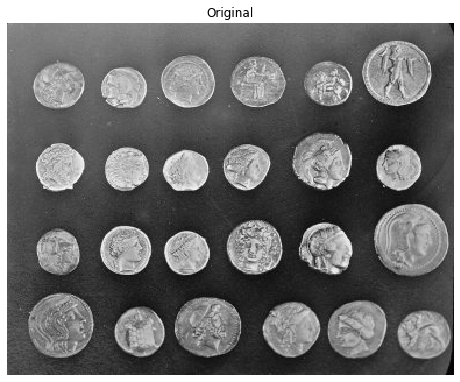

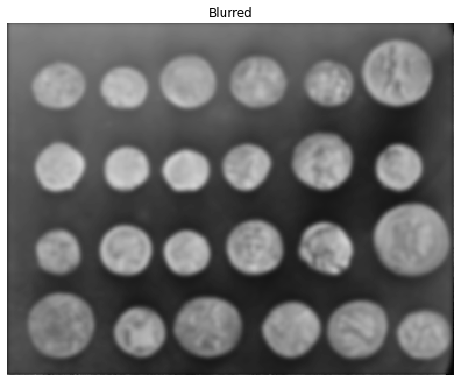

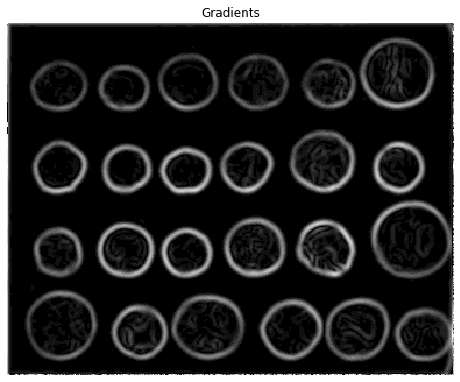

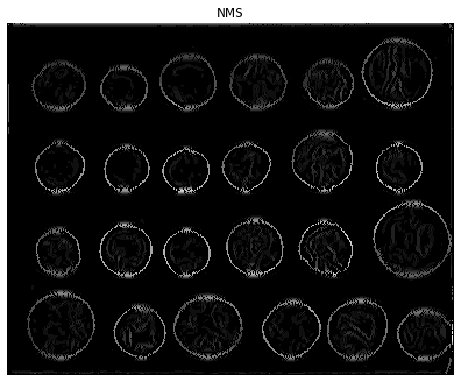

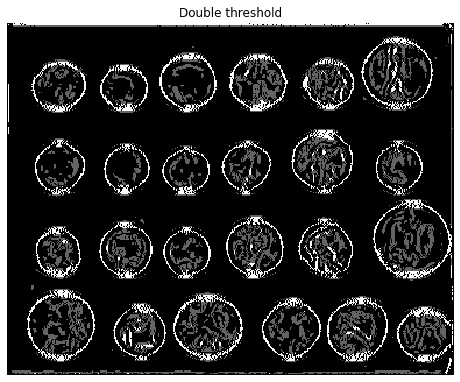

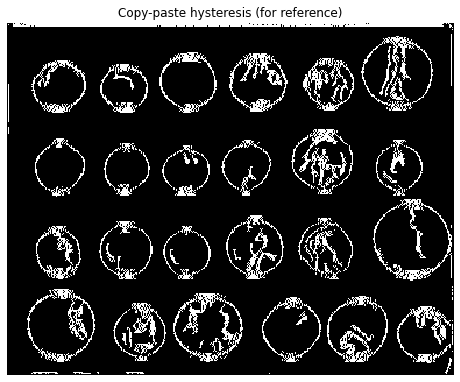

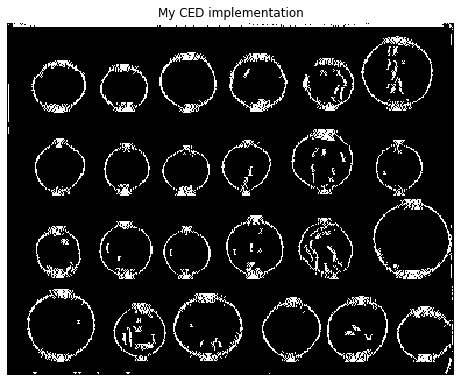

In [368]:
# with steps
display(CED(OGcoins, True, (21,21), 2, 0.05, 1, 0.1, 0.2), "My CED implementation")

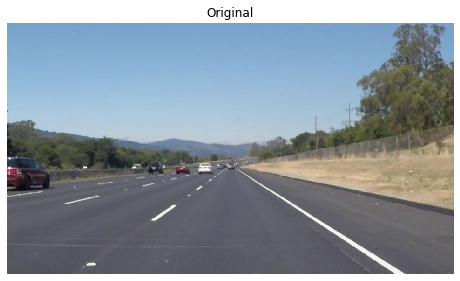

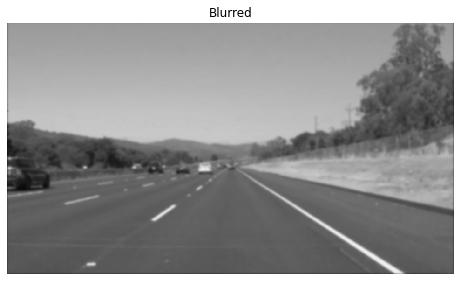

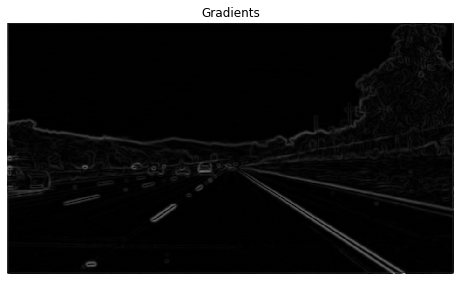

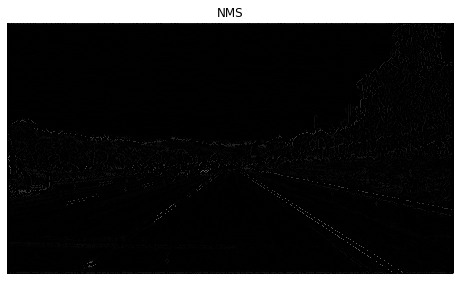

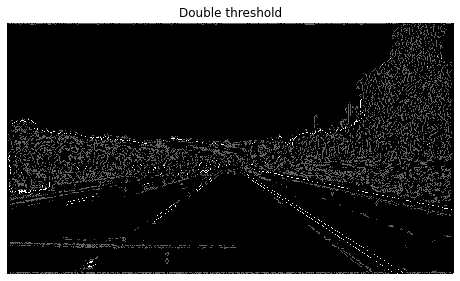

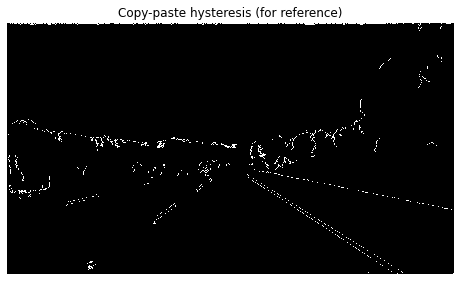

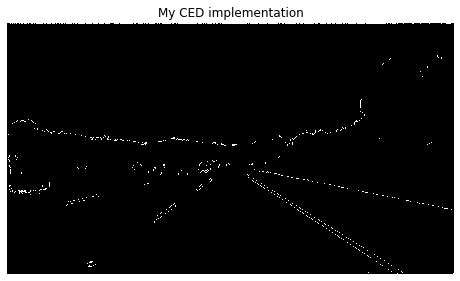

In [367]:
# with steps
display(CED(OGroad, True), "My CED implementation")

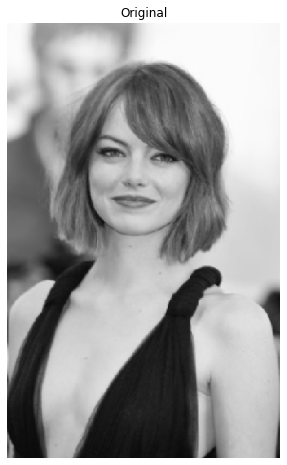

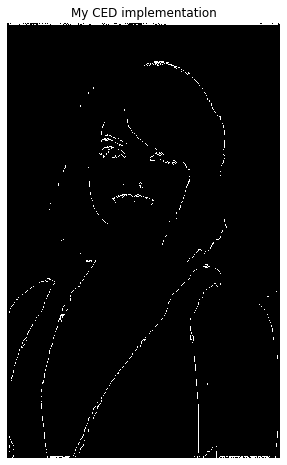

In [359]:
display(OGlady, "Original", "rgb")
display(CED(OGlady, False, (21,21), 2, 1, 3, 0.1, 0.2), "My CED implementation")

Here I laugh because I used to run my CED on the bridge image back when I was reading the files in the BGR color space (thanks, cv2). And, it turns out, for some reason, that when I ran the CED over the BGR image it turned out a better results, lol. I figure this has to do with the conversion from rgb to grayscale that I have in the `ncf()` function, where those multipliers will be affecting the wrong color. Anyway, I included the results both RGB and BGR for fun. I did notice the same thing happen with the road image above.

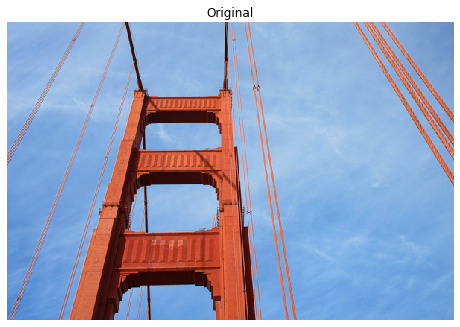

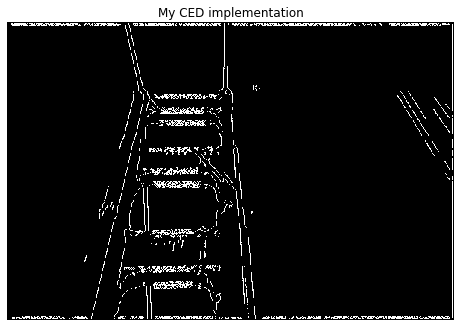

In [360]:
display(OGbridge, "Original", "rgb")
display(CED(OGbridge, False), "My CED implementation")

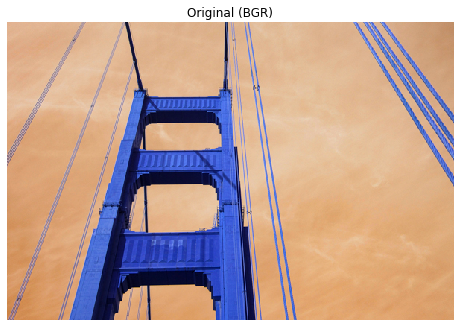

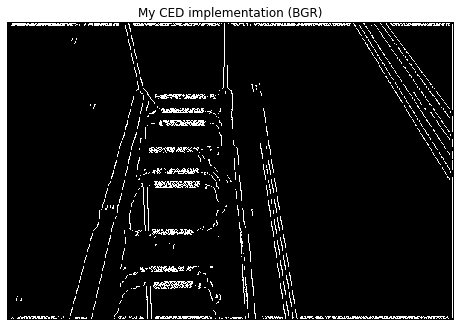

In [361]:
BGRbridge = cv2.imread('./images/bridge.jpg', cv2.IMREAD_COLOR)
display(BGRbridge, "Original (BGR)", "rgb")
display(CED(BGRbridge, False), "My CED implementation (BGR)")

Doesn't this look cool?!?

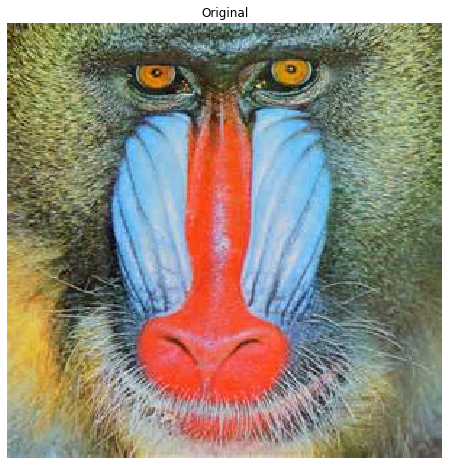

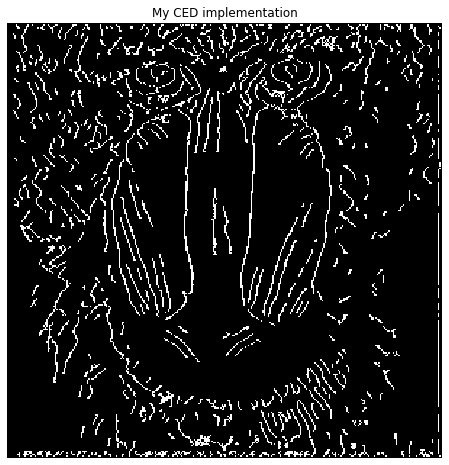

In [364]:
display(OGbaboon, "Original", "rgb")
display(CED(OGbaboon, False), "My CED implementation")

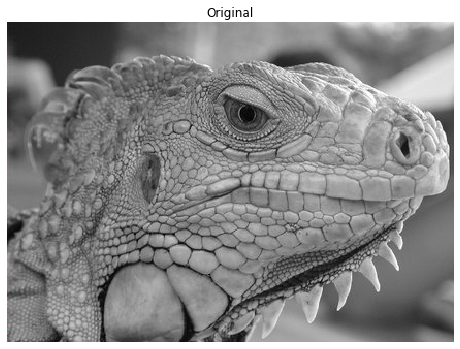

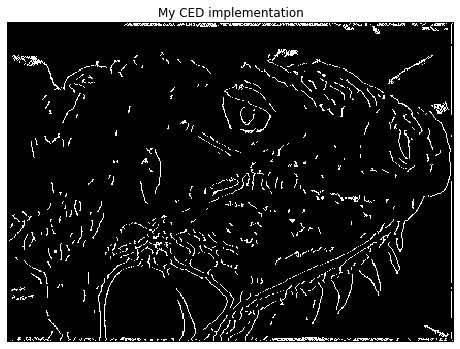

In [362]:
display(OGiguana, "Original")
display(CED(OGiguana, False), "My CED implementation")

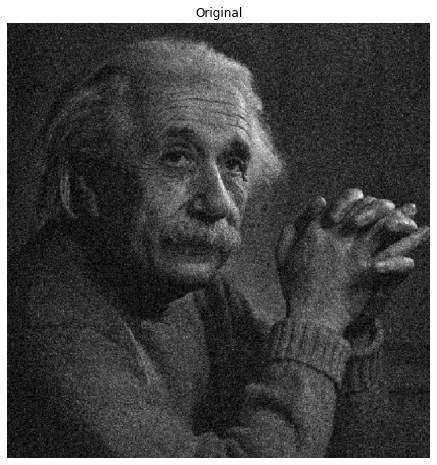

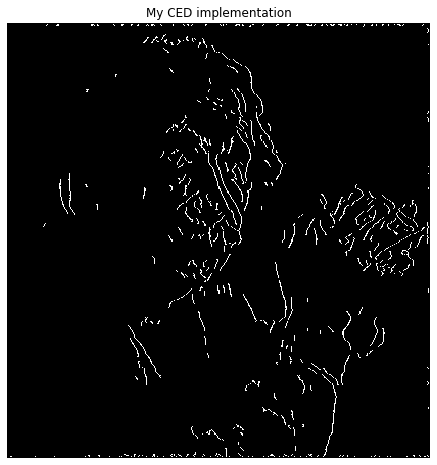

In [363]:
display(OGeinstein, "Original")
display(CED(OGeinstein, False), "My CED implementation")